# *nciraspw* – The NCI Ras pathway as a GraphViz Python object.

[![tests](https://github.com/jhrcook/nciraspw/actions/workflows/tests.yaml/badge.svg)](https://github.com/jhrcook/nciraspw/actions/workflows/tests.yaml)
[![codecov](https://codecov.io/gh/jhrcook/nciraspw/branch/master/graph/badge.svg?token=0UM60G1CM0)](https://codecov.io/gh/jhrcook/nciraspw)

The [National Cancer Institute (NCI) Ras pathway](https://www.cancer.gov/research/key-initiatives/ras/ras-central/blog/2015/ras-pathway-v2) is a manually-curated diagram of the Ras signaling pathway.
This Python package provides easy access to the data files and the pathway as a [NetworkX](https://networkx.org/) graph object.

![NCI Ras pathway 2.0 diagram](nciraspw/ras_pw_data/ras-pathway-enlarge.jpeg)

## Installation

This package is not released on PyPI at the moment, but it can be installed from GitHub using the following command.

```bash
pip install git+https://github.com/jhrcook/nciraspw.git
```

## Use

### Raw data files

The raw data for the pathway is bundled with the package and available through the `read_data` module.
The read functions are demonstrated below.

In [1]:
from nciraspw import read_data

A table of gene names, protein names, and alternative gene names are provided on the website.

In [2]:
read_data.read_gene_names().head()

,gene_name,protein_name,alt_gene_names
0,AKT1,RAC-alpha serine/threonine-protein kinase,"AKT, CWS6, PKB, PKB-ALPHA, PRKBA, RAC, RAC-ALPHA"
1,AKT2,RAC-beta serine/threonine-protein kinase,"HIHGHH, PKBB, PKBBETA, PRKBB, RAC-BETA"
2,AKT3,RAC-gamma serine/threonine-protein kinase,"MPPH, MPPH2, PKB-GAMMA, PKBG, PRKBG, RAC-PK-ga..."
3,ALK,anaplastic lymphoma receptor tyrosine kinase; ...,"CD246, NBLST3"
4,APAF1,apoptotic peptidase activating factor 1,"APAF-1, CED4"


The pathway had many proteins grouped together.
I transcribed these groups into a table along with their relative $x$ and $y$ locations.

In [3]:
read_data.read_node_groups().head()

,group_id,x,y,node
0,1,2302,0,CBL
1,1,2302,0,CBLB
2,1,2302,0,CBLC
3,2,3374,0,ALK
4,2,3374,0,EGFR


I also transcribed the edges from the pathway to a data frame, recording the links between node groups and the type of interaction.

In [4]:
read_data.read_node_group_interactions().head()

,from_grp,to_grp,interaction_type
0,1,2,inhibitory
1,2,4,activating
2,3,4,activating
3,4,7,activating
4,4,9,activating


The group interactions can be expanded to the individual proteins, too.

In [5]:
read_data.read_edge_list().head()

,from,to,interaction_type
0,CBL,ALK,inhibitory
1,CBL,EGFR,inhibitory
2,CBL,ERBB2,inhibitory
3,CBL,FGFR1,inhibitory
4,CBL,FGFR2,inhibitory


### Pathway graph object

The pathway is also available as a NetworkX directed graph object.

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

from nciraspw.layout import nci_ras_pathway_positions
from nciraspw.ras_pw_graph import ras_pathway_graph

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
ras_pw = ras_pathway_graph()
print(ras_pw)

DiGraph named 'NCI Ras pathway 2.0' with 228 nodes and 933 edges


In [8]:
list(ras_pw.nodes.data())[0]

('AKT1',
 {'protein_name': 'RAC-alpha serine/threonine-protein kinase',
  'alt_gene_names': {'AKT',
   'CWS6',
   'PKB',
   'PKB-ALPHA',
   'PRKBA',
   'RAC',
   'RAC-ALPHA'},
  'group_id': '41'})

In [9]:
list(ras_pw.edges.data())[0]

('AKT1', 'TSC1', {'interaction': 'inhibitory'})

To help with visualizing the pathway, I have indlcuded a custom layout function that uses the node group locations as starting points and then spreads out the individual nodes.
The amount of spread can be controlled by the `scale` and `eps` parameters in the layout function.

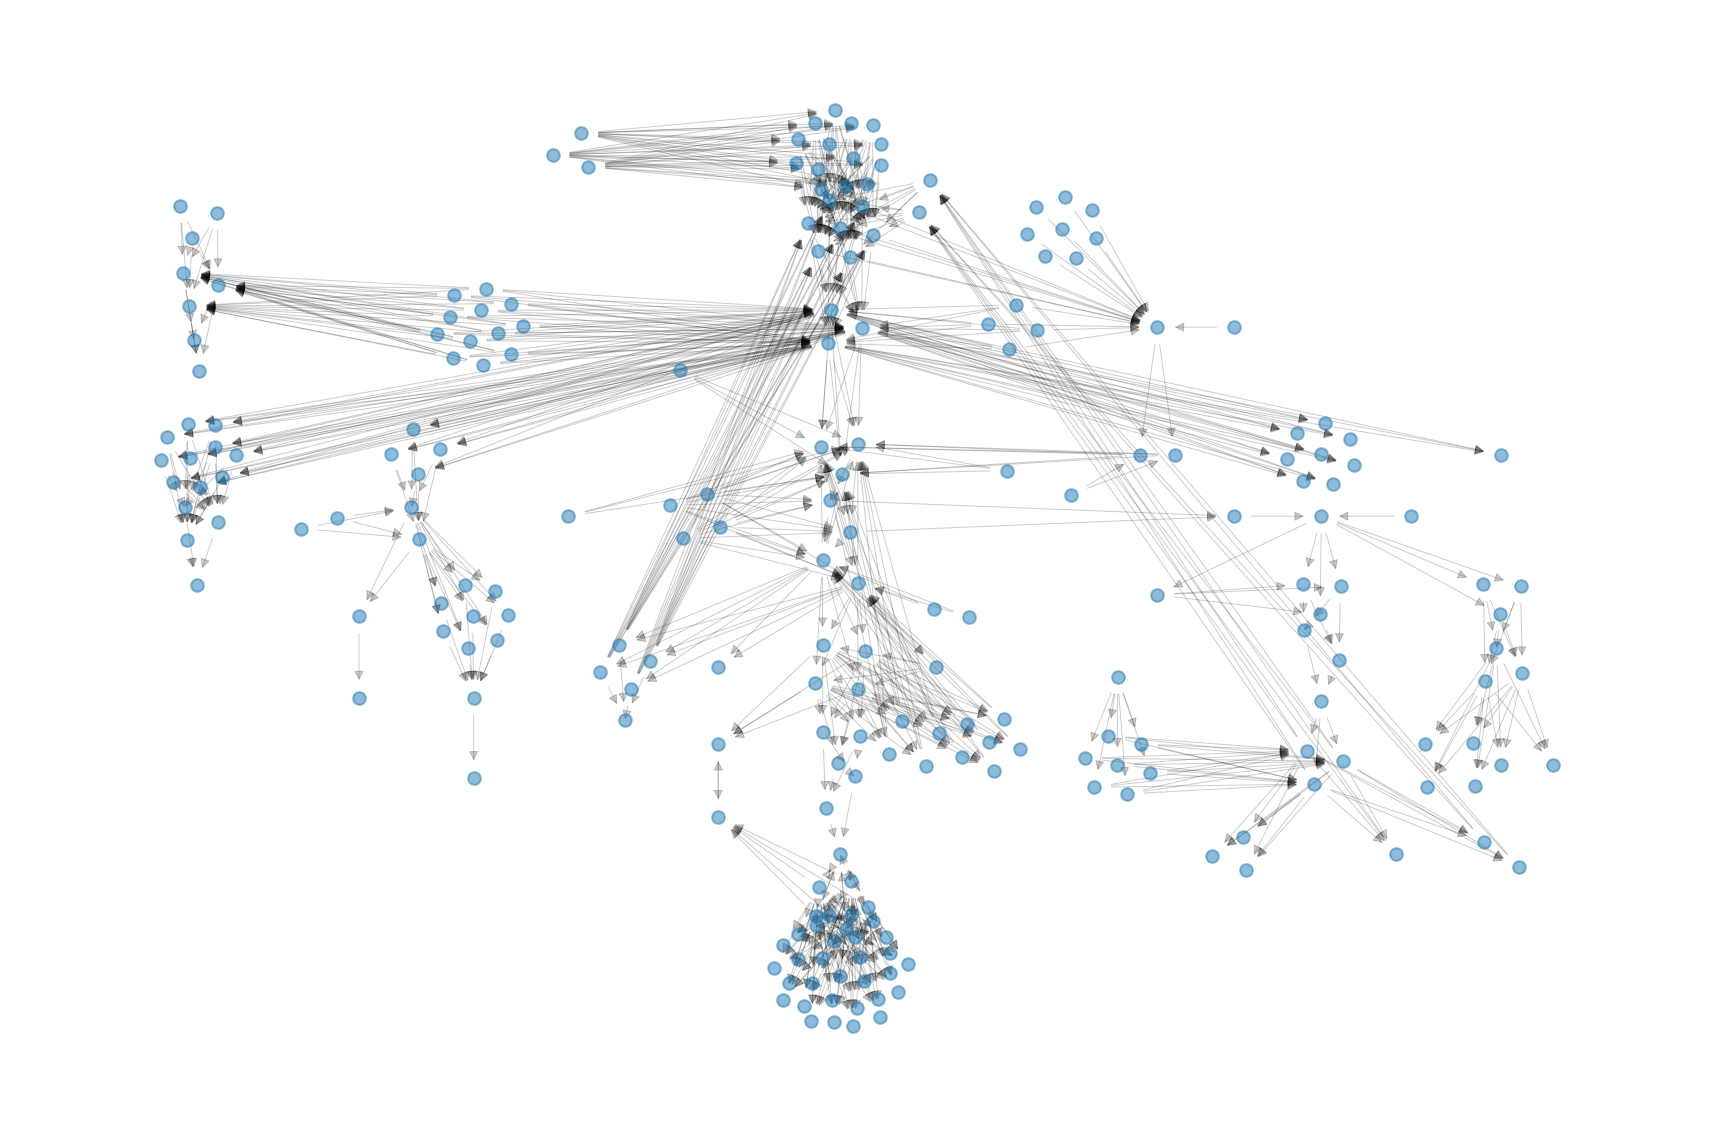

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

layout = nci_ras_pathway_positions(ras_pw, scale=50, eps=0.5)
nx.draw_networkx_edges(
    ras_pw, pos=layout, alpha=0.2, width=0.5, min_source_margin=2, min_target_margin=2
)
nx.draw_networkx_nodes(ras_pw, pos=layout, alpha=0.5, node_size=40)

ax.axis("off")
fig.tight_layout()
plt.show()

Below is just a demonstration of manipulating the pathway graph.
I extract the core of the pathway and some off-shoots to key downstream effectors.

In [11]:
from itertools import product

proteins = {"EGFR", "KRAS", "BRAF", "MAPK1", "RB1", "TP53", "MDM2", "FOSL1", "MYC"}
path_nodes = proteins.copy()
for a, b in product(proteins, proteins):
    if a == b:
        continue
    try:
        for path in nx.all_shortest_paths(ras_pw, a, b):
            path_nodes = path_nodes.union(path)
    except nx.NetworkXNoPath:
        ...

sub_ras_gr = nx.subgraph(ras_pw, path_nodes)
print(sub_ras_gr)

DiGraph named 'NCI Ras pathway 2.0' with 41 nodes and 144 edges


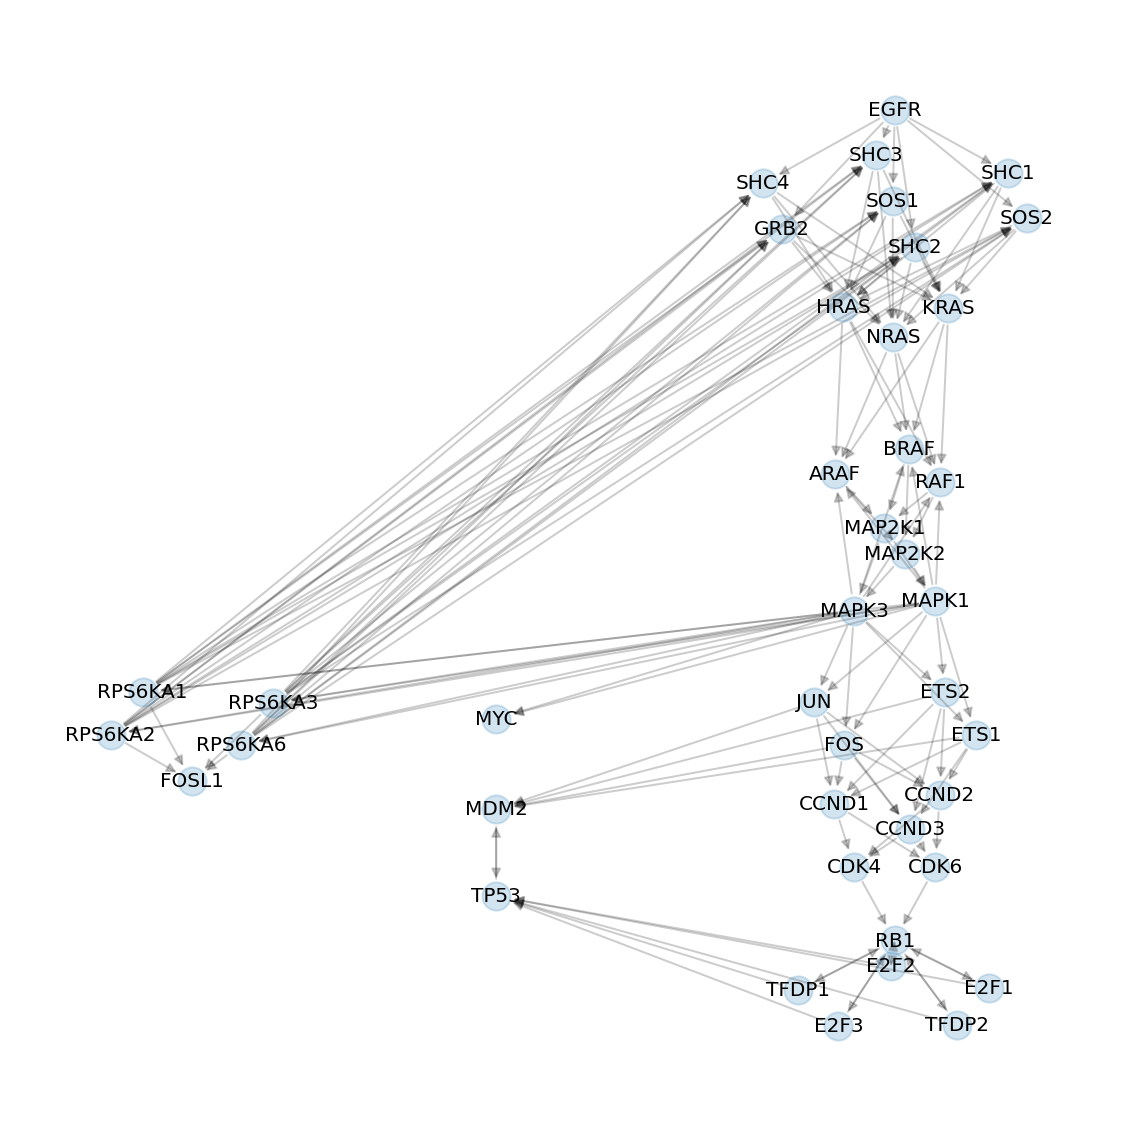

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

subgraph_pos = nci_ras_pathway_positions(sub_ras_gr, scale=25, eps=1)
nx.draw_networkx_edges(sub_ras_gr, pos=subgraph_pos, alpha=0.2)
nx.draw_networkx_nodes(sub_ras_gr, pos=subgraph_pos, alpha=0.2, node_size=200)
nx.draw_networkx_labels(sub_ras_gr, pos=subgraph_pos, font_size=10)

ax.axis("off")
fig.tight_layout()
plt.show()